### Dropping Redundant Columns from Google Sheet

In [1]:
import pandas as pd
import spacy

In [16]:
df = pd.read_csv('data_giacomo_cleaned_restriced.csv')

In [52]:
pd.reset_option('display.max_colwidth')


In [17]:
df.drop(columns=['Unnamed: 13', 'Unnamed: 14', 
                 'Unnamed: 15', 'headline', 
                 'description', 'file_link', 
                 'Harry_label','Giacomo_label', 
                 'Johan_label', 'Translation', 
                 'Random Index'], inplace=True)

In [19]:
df.to_csv('data_giacomo_cleaned_restriced.csv', index=False)

### Adding Labels to dataset

In [55]:
# no_labels_df = pd.read_csv('df_merged_FULL_corrected_spelling_last.csv')
labels_df = pd.read_csv('data_giacomo_cleaned_restriced.csv')

df_merged = pd.merge(
    no_labels_df,
    labels_df,
    on=['id', 'file_number'],
    how='inner'  # 'inner' keeps only matching rows
)

df_merged.drop(columns=['parties_list'], inplace=True)
df_merged.to_csv('df_merged_FULL_corrected_spelling_last.csv', index=False)

In [ ]:
df_merged.columns

### 4.2 Ontvanger

#### Preprocessing

In [ ]:
df_merged = pd.read_csv('df_merged_FULL_corrected_spelling_last.csv')

# Convert the 'party_labeled' column into lists by splitting on commas
df_merged['party_labeled'] = df_merged['party_labeled'].apply(lambda x: x.split(',') if pd.notnull(x) else [])
df_merged['headline_and_description'] = df_merged['headline'] + '. ' + df_merged['description']

df_merged.sample(2)

In [401]:
# Filter out rows where 'parties' is exactly 'Leveringsvergunningen Kleinverbruik Ex Art. 45 Gaswet'
df_merged_filtered = df_merged[
    df_merged['parties'] != 'Leveringsvergunningen Kleinverbruik Ex Art. 45 Gaswet'
].copy()


# Optional: Display the number of rows removed
print(f"Number of rows removed: {len(df_merged) - len(df_merged_filtered)}")

Number of rows removed: 26


#### Baseline NER

In [14]:
pd.set_option('display.max_colwidth', None)

In [402]:
# Load the Dutch language model with NER capabilities
nlp = spacy.load("nl_core_news_lg")

def extract_organizations(text: str) -> list:
    """
    Extracts all organizations (ORG entities) from the provided text.
    
    :param text: A string containing the text to process.
    :return: A list of organization names identified in the text.
    """
    doc = nlp(text)
    
    # Extract and return all entities labeled as ORG
    organizations = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    return organizations

df_temp = df_merged_filtered.head(20).copy()

# Apply the function to extract organizations and store them in a new column
df_temp['organizations'] = df_temp['headline_and_description'].apply(extract_organizations)

df_temp[["party_labeled", "organizations"]].sample(10, random_state=7)

,party_labeled,organizations
1,[TotalEnergies Gas & Power Nederland B.V.],[ACM]
17,[Gemeente Hengelo],[ACM]
2,[HVC Energie B.V.],"[HVC, ACM, HVC]"
5,[Energie der Nederlanden],[ACM]
11,[e-Energy Europe B.V.],[ACM]
0,[TotalEnergies Gas & Power Nederland B.V.],[ACM]
18,"[Greenfoot Energy B.V., Energyhouse B.V.]",[]
6,[Holthausen Clean Energy B.V.],"[Clean Energy, ACM]"
13,[Duurzame Energie Veenendaal-oost (DEVO) B.V.],[ACM]
19,"[Greenfoot Energy B.V., Energyhouse B.V.]",[]


In [403]:
print(df_temp[["party_labeled", "organizations"]].sample(10, random_state=7).to_latex())

\begin{tabular}{lll}
\toprule
 & party_labeled & organizations \\
\midrule
1 & ['TotalEnergies Gas & Power Nederland B.V.'] & ['ACM'] \\
17 & ['Gemeente Hengelo'] & ['ACM'] \\
2 & ['HVC Energie B.V.'] & ['HVC', 'ACM', 'HVC'] \\
5 & ['Energie der Nederlanden'] & ['ACM'] \\
11 & ['e-Energy Europe B.V.'] & ['ACM'] \\
0 & ['TotalEnergies Gas & Power Nederland B.V.'] & ['ACM'] \\
18 & ['Greenfoot Energy B.V.', ' Energyhouse B.V.'] & [] \\
6 & ['Holthausen Clean Energy B.V.'] & ['Clean Energy', 'ACM'] \\
13 & ['Duurzame Energie Veenendaal-oost (DEVO) B.V.'] & ['ACM'] \\
19 & ['Greenfoot Energy B.V.', ' Energyhouse B.V.'] & [] \\
\bottomrule
\end{tabular}



#### Custom NER

In [405]:
from sklearn.model_selection import train_test_split

# Perform a train-test split on unique 'id' values
unique_ids = df_merged_filtered['id'].unique()

# Split the unique IDs into train and test sets
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# Split the original dataframe based on the unique 'id'
train_df = df_merged_filtered[df_merged_filtered['id'].isin(train_ids)]
test_df = df_merged_filtered[df_merged_filtered['id'].isin(test_ids)]

# Print the number of unique IDs
print(f"Number of unique IDs: {len(unique_ids)}")

# Print the number of decisions in the training set
print(f"Number of decisions in the training set: {len(train_df)}")

# Print the number of decisions in the test set
print(f"Number of decisions in the test set: {len(test_df)}")

Number of unique IDs: 286
Number of decisions in the training set: 264
Number of decisions in the test set: 69


### NER exact matches in train

In [ ]:
import re

def prepare_training_data(df):
    """
    Prepares training data for spaCy NER from a DataFrame using exact substring matching,
    with additional checks by removing and appending common suffixes.

    :param df: A DataFrame containing headlines and ground truth ontvangers.
    :return: A list of tuples (headline_and_descriptions, entities, original_parties).
    """
    training_data = []

    # Define suffix patterns and variants
    suffix_variants = [" B.V.", " BV", " B.V", " BV.", ""]  # Common suffix variations
    suffix_patterns = [r'\sB\.V\.$', r'\sBV$', r'\sB\.V$', r'\sBV\.$']  # Regex patterns to strip suffixes

    for idx, row in df.iterrows():
        headline = row['headline_and_description']
        ontvangers = row['party_labeled']  # Ground truth ontvangers (as a list)

        # Validate row data
        if pd.notna(headline) and isinstance(ontvangers, list):
            for ontvanger in ontvangers:
                matched = False  # Track if a match was found

                ## 1. Exact Match
                start = headline.lower().find(ontvanger.lower())
                if start != -1:
                    end = start + len(ontvanger)
                    training_data.append((headline, [(start, end, "ORG")], ontvanger))
                    matched = True
                    continue  # Move to the next entity if matched

                ## 2. Match Without Suffix
                ontvanger_no_suffix = ontvanger
                for pattern in suffix_patterns:
                    ontvanger_no_suffix = re.sub(pattern, '', ontvanger_no_suffix).strip()

                if ontvanger_no_suffix and ontvanger_no_suffix != ontvanger:
                    start = headline.lower().find(ontvanger_no_suffix.lower())
                    if start != -1:
                        end = start + len(ontvanger_no_suffix)
                        training_data.append((headline, [(start, end, "ORG")], ontvanger))
                        matched = True
                        continue  # Move to the next entity if matched

                ## 3. Match With Suffix Variants
                for variant in suffix_variants:
                    entity_to_match = ontvanger_no_suffix.strip() + variant
                    start = headline.lower().find(entity_to_match.lower())

                    if start != -1:
                        end = start + len(entity_to_match)
                        training_data.append((headline, [(start, end, "ORG")], ontvanger))
                        matched = True
                        break  # Stop checking other variants if a match is found

                ## 4. Log Unmatched Entities
                if not matched:
                    print(f"Warning: Ontvanger '{ontvanger}' not found in headline: {headline}")

    return training_data

# Prepare the dataset with entities for training and testing
NER_LABELS_SPACY_TRAIN = prepare_training_data(train_df)
NER_LABELS_SPACY_TEST = prepare_training_data(test_df)


In [ ]:
# visualize fuzzy matched training data
from spacy import displacy
import random
from IPython.display import HTML

def visualize_fuzzy_matched_training_data(training_data, num_examples=5, seed=42):
    """
    Visualizes examples of fuzzy-matched training data using spaCy's displacy.

    :param training_data: List of training examples in the format (headline_and_description, entities, original_party).
    :param num_examples: Number of examples to visualize.
    :param seed: Seed for random sampling (default: 42).
    """
    # Set the random seed for reproducibility
    random.seed(seed)
    
    # Randomly sample examples from the training data
    sampled_data = random.sample(training_data, min(num_examples, len(training_data)))
    
    for headline_and_description, entities, original_party in sampled_data:
        # Create visualization data
        ents = [{"start": start, "end": end, "label": label} for start, end, label in entities]
        visualization_data = {"text": headline_and_description, "ents": ents, "title": "Training Data"}
        
        # Render displacy visualization as HTML
        displacy_html = displacy.render(visualization_data, style="ent", manual=True, jupyter=False)
        
        # Combine textual details and visualization into a styled box
        box_style = """
        <div style="
            border: 1px solid #ddd;
            border-radius: 8px;
            padding: 15px;
            margin: 10px 0;
            background-color: #f9f9f9;">
        """
        
        details = f"""
        {box_style}
        <strong>Headline & Description:</strong> {headline_and_description}<br>
        <strong>Entity Extracted for NER Training:</strong> {', '.join([headline_and_description[start:end] for start, end, _ in entities])}<br>
        <strong>Ground Truth:</strong> {original_party}<br><br>
        {displacy_html}
        </div>
        """
        
        # Display the styled box with content
        display(HTML(details))

# Visualize examples from NER_LABELS_SPACY
visualize_fuzzy_matched_training_data(NER_LABELS_SPACY_TRAIN, num_examples=5, seed=42)

In [ ]:
import spacy
from spacy.training import Example
import random
import matplotlib.pyplot as plt

def train_ner_model(train_data, base_model="nl_core_news_lg", n_iter=50):
    """
    Trains a custom NER model using spaCy and plots the training losses.

    :param train_data: List of training examples in the format (headline, entities, original_party).
    :param base_model: The base spaCy model to fine-tune.
    :param n_iter: Number of training iterations.
    :return: The trained spaCy model and a list of losses per epoch.
    """
    # Load the base model
    nlp = spacy.load(base_model)
    ner = nlp.get_pipe("ner")
    ner.add_label("ORG")

    # Prepare training examples, excluding the original party
    examples = [
        Example.from_dict(nlp.make_doc(headline), {"entities": entities})
        for headline, entities, _ in train_data  # Ignore the original party
    ]

    # Train the NER model and track losses
    optimizer = nlp.initialize()
    epoch_losses = []

    for epoch in range(n_iter):
        losses = {}
        random.shuffle(examples)
        nlp.update(examples, sgd=optimizer, losses=losses)
        epoch_losses.append(losses["ner"])
        print(f"Losses at iteration {epoch}: {losses}")

    # Plot the losses over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_iter + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title("NER Training Losses Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

    return nlp, epoch_losses

# Train the model and plot losses
custom_ner, losses = train_ner_model(NER_LABELS_SPACY_TRAIN)


In [ ]:
def evaluate_ner_model(nlp, test_data):
    """
    Evaluates the custom NER model on a test dataset.

    :param nlp: The trained spaCy model.
    :param test_data: List of test examples in the format (headline, entities, original_party).
    :return: Precision, recall, and F1-score.
    """
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives

    for headline, entities, _ in test_data:  # Unpack headline and entities, ignore original_party
        doc = nlp(headline)
        predicted_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        true_entities = entities

        # Compare predicted and true entities
        for pred in predicted_entities:
            if pred in true_entities:
                tp += 1
            else:
                fp += 1

        for true_ent in true_entities:
            if true_ent not in predicted_entities:
                fn += 1

    # Calculate precision, recall, and F1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Evaluate the model
precision, recall, f1 = evaluate_ner_model(custom_ner, NER_LABELS_SPACY_TEST)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")

In [ ]:
from spacy import displacy

def visualize_test_examples_with_displacy(nlp, test_data, num_examples=5):
    """
    Visualizes true and predicted entities from the test set using spaCy's displacy.

    :param nlp: The trained spaCy model.
    :param test_data: List of test examples in the format (headline, entities, original_party).
    :param num_examples: Number of examples to visualize.
    """
    examples_shown = 0

    # Define custom color options
    ground_truth_colors = {"ORG": "green"}
    predicted_colors = {"ORG": "yellow"}

    for headline, entities, original_party in test_data:
        # Stop if the desired number of examples is reached
        if examples_shown >= num_examples:
            break

        # Print metadata
        print(f"Example {examples_shown + 1}")
        print(f"Original Party (Ground Truth): {original_party}")
        print(f"Headline: {headline}")
        
        # True entities visualization
        true_ents = [{"start": start, "end": end, "label": label} for start, end, label in entities]
        true_render = {"text": headline, "ents": true_ents, "title": "True Entities"}
        displacy.render(true_render, style="ent", manual=True, jupyter=True, options={"colors": ground_truth_colors})

        # Predicted entities visualization
        doc = nlp(headline)
        predicted_ents = [{"start": ent.start_char, "end": ent.end_char, "label": ent.label_} for ent in doc.ents]
        predicted_render = {"text": headline, "ents": predicted_ents, "title": "Predicted Entities"}
        displacy.render(predicted_render, style="ent", manual=True, jupyter=True, options={"colors": predicted_colors})

        print("-" * 80)  # Separator between examples
        examples_shown += 1

# Visualize examples
visualize_test_examples_with_displacy(custom_ner, NER_LABELS_SPACY_TEST, num_examples=20)

### NER Fuzzy matches - FINAL

In [340]:
import re

def normalize_label_bv(label):
    """
    If `label` ends with something like 'B.V.' (case-insensitive), remove it 
    and return the remainder as the 'base label'.
    Otherwise, return the label itself (after trimming whitespace).
    """
    label = label.strip()
    # Regex to detect trailing B.V. (with optional punctuation/whitespace)
    # e.g. "B.V", "B. V.", "BV", etc., ignoring case
    bv_pattern = re.compile(r"\s+B\.?\s*V\.?$", re.IGNORECASE)

    # Sub out the trailing B.V. if present
    base_label = re.sub(bv_pattern, "", label)
    return base_label.strip()

def build_label_bv_pattern(base_label):
    """
    Return a regex that matches either:
      1) base_label alone
      2) base_label + optional B.V. (with various punctuation/whitespace)
    Case-insensitive, using word boundaries.
    """
    escaped_label = re.escape(base_label)
    # Group that can optionally match " B.V." or " BV" or " b.v." etc.
    bv_suffix = r"(?:\s+B\.?\s*V\.?)?"
    # Put it all together with word boundaries
    pattern_str = rf"\b{escaped_label}{bv_suffix}\b"
    return re.compile(pattern_str, flags=re.IGNORECASE)

def find_bv_variants_in_text(text, label):
    """
    Given the original label, build a pattern that can match either
    the 'base label' or 'base label + B.V.'. Return all matches (start, end).
    """
    # 1) Normalize label to remove 'B.V.' if present
    base_label = normalize_label_bv(label)
    
    # 2) Build a pattern that matches:
    #    a) base_label alone
    #    b) base_label + optional "B.V."
    pattern = build_label_bv_pattern(base_label)

    entities = []
    for match in pattern.finditer(text):
        start, end = match.start(), match.end()
        # We'll call them all "ORG" for demonstration
        entities.append((start, end, "ORG"))
    
    return entities

def prepare_training_data(df):
    """
    For each row in df:
      - Get 'headline_and_description' and 'party_labeled'
      - For each label in 'party_labeled', match either:
          * label alone (if it didn't have B.V.)
          * label minus B.V. + optional B.V.
      - Return list of (text, entities, original_labels) for spaCy.
    """
    training_data = []

    for idx, row in df.iterrows():
        headline = row.get("headline_and_description", "")
        ontvangers = row.get("party_labeled", [])

        # Ensure headline is not NaN and ontvangers is a list
        if pd.notna(headline) and isinstance(ontvangers, list) and ontvangers:
            entities = []
            
            for label in ontvangers:
                matches = find_bv_variants_in_text(headline, label)
                entities.extend(matches)

            if entities:
                training_data.append((headline, entities, ontvangers))
    
    return training_data

NER_LABELS_SPACY_TRAIN = prepare_training_data(train_df)
# NER_LABELS_SPACY_TEST  = prepare_training_data(test_df)

Visualizing training entities

In [275]:
from spacy import displacy

def visualize_training_data(training_data, num_examples=5, seed=42):
    """
    Visualizes examples of fuzzy-matched training data using spaCy's displacy.

    :param training_data: List of training examples in the format (headline, entities, original_party).
    :param num_examples: Number of examples to visualize.
    :param seed: Seed for random sampling (default: 42).
    """
    # Set the random seed for reproducibility
    random.seed(seed)
    
    # Randomly sample examples from the training data
    sampled_data = random.sample(training_data, min(num_examples, len(training_data)))
    
    for headline, entities, original_party in sampled_data:
        # Create visualization data
        ents = [{"start": start, "end": end, "label": label} for start, end, label in entities]
        visualization_data = {"text": headline, "ents": ents, "title": "Training Data"}
        
        # Render displacy visualization as HTML
        displacy_html = displacy.render(visualization_data, style="ent", manual=True, jupyter=False)
        
        # Combine textual details and visualization into a styled box
        box_style = """
        <div style="
            border: 1px solid #ddd;
            border-radius: 8px;
            padding: 15px;
            margin: 10px 0;
            background-color: #f9f9f9;">
        """
        
        details = f"""
        {box_style}
        <strong>Headline:</strong> {headline}<br>
        <strong>Entity Extracted for NER Training:</strong> {', '.join([headline[start:end] for start, end, _ in entities])}<br>
        <strong>Original Party (Ground Truth):</strong> {original_party}<br><br>
        {displacy_html}
        </div>
        """
        
        # Display the styled box with content
        display(HTML(details))

# Visualize examples from NER_LABELS_SPACY_TRAIN
visualize_training_data(NER_LABELS_SPACY_TRAIN, num_examples=10, seed=42)


training 1

Overlapping entity ignored: (220, 225, ORG)
Overlapping entity ignored: (25, 37, ORG)
Overlapping entity ignored: (55, 67, ORG)
Overlapping entity ignored: (87, 104, ORG)
Overlapping entity ignored: (178, 195, ORG)
Epoch 1/30, Loss: 537.6740
Epoch 2/30, Loss: 204.0992
Epoch 3/30, Loss: 182.0275
Epoch 4/30, Loss: 112.3885
Epoch 5/30, Loss: 122.5945
Epoch 6/30, Loss: 105.9491
Epoch 7/30, Loss: 99.3598
Epoch 8/30, Loss: 95.1619
Epoch 9/30, Loss: 90.2659
Epoch 10/30, Loss: 94.0796
Epoch 11/30, Loss: 80.8150
Epoch 12/30, Loss: 78.4236
Epoch 13/30, Loss: 67.3875
Epoch 14/30, Loss: 68.9089
Epoch 15/30, Loss: 85.3025
Epoch 16/30, Loss: 66.4804
Epoch 17/30, Loss: 73.0445
Epoch 18/30, Loss: 58.3962
Epoch 19/30, Loss: 64.3932
Epoch 20/30, Loss: 77.2144
Epoch 21/30, Loss: 62.1276
Epoch 22/30, Loss: 56.3193
Epoch 23/30, Loss: 59.1997
Epoch 24/30, Loss: 56.4381
Epoch 25/30, Loss: 67.8602
Epoch 26/30, Loss: 62.6757
Epoch 27/30, Loss: 68.3684
Epoch 28/30, Loss: 58.0147
Epoch 29/30, Loss: 53.3182
Epoch

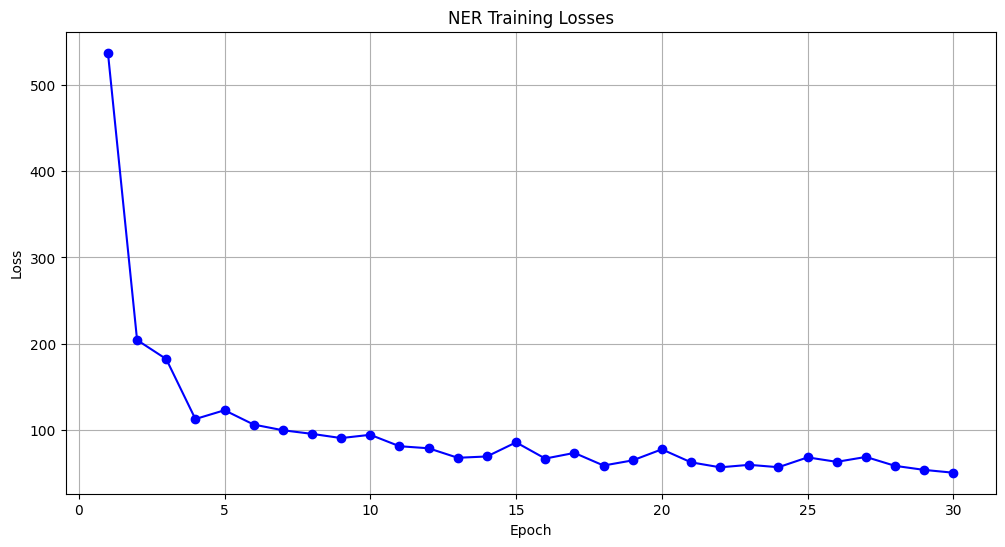

In [ ]:
import spacy
from spacy.training import Example
import random
import matplotlib.pyplot as plt

def align_entities(nlp, text, entities):
    """
    Align entities with token boundaries using SpaCy's tokenizer.
    """
    doc = nlp.make_doc(text)
    aligned_entities = []
    
    for start, end, label in entities:
        token_start = None
        token_end = None
        
        # Find token boundaries
        for token in doc:
            if token.idx <= start < token.idx + len(token.text):
                token_start = token.idx
            if token.idx < end <= token.idx + len(token.text):
                token_end = token.idx + len(token.text)
        
        if token_start is not None and token_end is not None:
            aligned_entities.append((token_start, token_end, label))
        else:
            print(f"Could not align entity: {(start, end, label)}")
    
    return aligned_entities


def prepare_aligned_training_data(train_data, nlp):
    """
    Ensure all entity offsets align with spaCy tokens and remove overlaps.
    """
    aligned_data = []
    for text, entities, _ in train_data:
        aligned_entities = align_entities(nlp, text, entities)
        non_overlapping_entities = remove_overlapping_entities(aligned_entities)
        aligned_data.append((text, non_overlapping_entities))
    return aligned_data


def remove_overlapping_entities(entities):
    """
    Remove overlapping entities from a list of entities.
    Keeps the longest entity in each overlapping pair.

    :param entities: List of tuples (start, end, label)
    :return: Filtered list of non-overlapping entities
    """
    if not entities:
        return []

    # Sort entities by start offset, and if equal, by descending length
    entities = sorted(entities, key=lambda x: (x[0], -(x[1] - x[0])))

    non_overlapping = []
    last_end = -1

    for start, end, label in entities:
        if start >= last_end:  # No overlap with the previous entity
            non_overlapping.append((start, end, label))
            last_end = end  # Update the end pointer
        else:
            print(f"Overlapping entity ignored: ({start}, {end}, {label})")

    return non_overlapping


import spacy
from spacy.training import Example
import random
import matplotlib.pyplot as plt


def train_ner_model(train_data, base_model="nl_core_news_lg", n_iter=50):
    """
    Trains a custom NER model using spaCy with aligned, non-overlapping entity data.
    """
    nlp = spacy.load(base_model)
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner")
    else:
        ner = nlp.get_pipe("ner")
    
    ner.add_label("ORG")
    
    # Align and remove overlaps from training data
    aligned_train_data = prepare_aligned_training_data(train_data, nlp)
    
    examples = [
        Example.from_dict(nlp.make_doc(text), {"entities": entities})
        for text, entities in aligned_train_data
    ]
    
    optimizer = nlp.resume_training()
    losses_history = []

    with nlp.disable_pipes(*[pipe for pipe in nlp.pipe_names if pipe != "ner"]):
        for epoch in range(n_iter):
            random.shuffle(examples)
            losses = {}
            for example in examples:
                nlp.update([example], sgd=optimizer, losses=losses, drop=0.2)
            losses_history.append(losses["ner"])
            print(f"Epoch {epoch + 1}/{n_iter}, Loss: {losses['ner']:.4f}")
    
    
    return nlp, losses_history


# Example Usage:
# Ensure your training data is aligned and cleaned
custom_ner, losses = train_ner_model(NER_LABELS_SPACY_TRAIN, n_iter=30)

# Save the model
#custom_ner.to_disk("custom_ner_model")

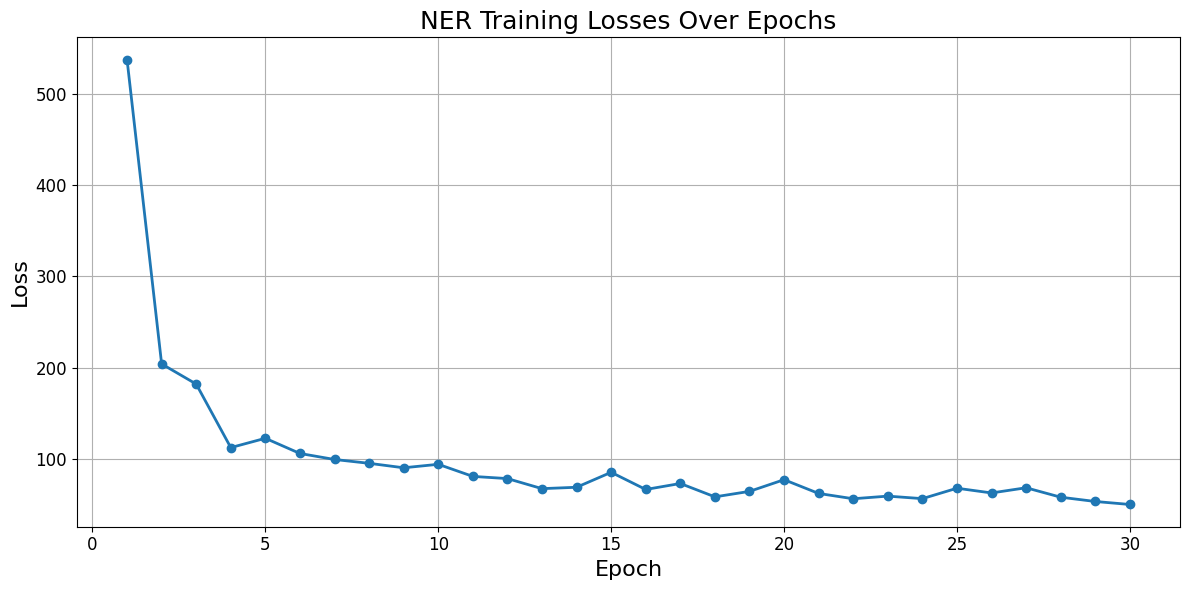

In [419]:
import matplotlib.pyplot as plt

# Plot Losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30 + 1), losses, marker='o', linestyle='-', linewidth=2)
plt.title("NER Training Losses Over Epochs", fontsize=18)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.xticks(fontsize=12)
plt.grid(True)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("/Users/giacomograzia/Downloads/ner_training_losses.png", dpi=300)
plt.show()


In [463]:
def add_predicted_org_entities_to_df(nlp, df, text_column):
    """
    Predict ORG entities for each text entry in a DataFrame and add them as indices and strings.
    
    :param nlp: Trained SpaCy NER model.
    :param df: pandas DataFrame containing text data.
    :param text_column: Column name containing the text data.
    :return: Updated DataFrame with two new columns:
             - 'predicted_org_indices': List of (start, end) tuples for ORG entities.
             - 'predicted_org_strings': List of ORG entity strings.
    """
    predicted_org_indices = []
    predicted_org_strings = []
    
    for text in df[text_column]:
        if pd.isna(text):  # Handle empty or NaN text fields
            predicted_org_indices.append([])
            predicted_org_strings.append([])
            continue
        
        # Apply NER to the text
        doc = nlp(text)
        
        # Extract ORG entities
        org_entities_indices = [(ent.start_char, ent.end_char) for ent in doc.ents if ent.label_ == "ORG"]
        org_entities_strings = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
        
        predicted_org_indices.append(org_entities_indices)
        predicted_org_strings.append(org_entities_strings)
    
    # Add new columns to the DataFrame
    df['predicted_org_indices'] = predicted_org_indices
    df['predicted_org_strings'] = predicted_org_strings
    
    return df


# Apply predictions to the 'headline_and_description' column
test_df = add_predicted_org_entities_to_df(custom_ner, test_df, 'headline_and_description')

def deduplicate_ground_truth(ground_truth_parties):
    """
    Deduplicate ground truth entities based on exact lowercase overlap.

    :param ground_truth_parties: List of ground truth party strings.
    :return: Deduplicated list of ground truth party strings.
    """
    if not ground_truth_parties or len(ground_truth_parties) == 1:
        return ground_truth_parties
    
    deduplicated = []
    seen = set()
    
    for party in ground_truth_parties:
        lowercase_party = party.lower().strip(' ')
        if lowercase_party not in seen:
            deduplicated.append(party)
            seen.add(lowercase_party)
        else:
            print(f"Duplicate removed: {party}")
    
    return deduplicated

test_df['party_labeled'] = test_df['party_labeled'].apply(deduplicate_ground_truth) 

Duplicate removed:  MAIN Energie B.V.


/var/folders/6r/fy40h3sj5sz87ctgpzyw1lgm0000gn/T/ipykernel_78871/251670350.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_org_indices'] = predicted_org_indices
/var/folders/6r/fy40h3sj5sz87ctgpzyw1lgm0000gn/T/ipykernel_78871/251670350.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_org_strings'] = predicted_org_strings
/var/folders/6r/fy40h3sj5sz87ctgpzyw1lgm0000gn/T/ipykernel_78871/251670350.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [464]:
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_colwidth')


test_df[test_df['id'] == 'id_acm_energy_permit_89']



,id,file_number,text_pypdf2,headline,description,publication_date,decision_date,case,parties,file_link,corrected_text_4omini_prompt_1,party_labeled,decision_category,headline_and_description,predicted_org_indices,predicted_org_strings
347,id_acm_energy_permit_89,1,acm/de/2017/206454 zaaknummer: 17.0430.53 besl...,Vergunning warmte Greenspread Warmte B.V. komt...,Betreft de naamswijziging van de leveringsverg...,2018-04-06,2017-12-21,ACM/17/043053,NaN,https://www.acm.nl/nl/publicaties/vergunning-w...,"{""corrected_text"":""acm/de/2017/206454 zaaknumm...","[Greenspread Warmte B.V., Eteck Warmte 7 B.V.]",wijziging of aanpassen (amend/modify),Vergunning warmte Greenspread Warmte B.V. komt...,"[(59, 77), (144, 167), (171, 190)]","[Eteck Warmte 7 B.V, Greenspread Warmte B.V., ..."


In [442]:
fuzz.ratio('TotalEnergies', 'TotalEnergies en gas Nederland N.V.')

54.16666666666667

In [473]:
from rapidfuzz import fuzz
import pandas as pd


def deduplicate_predictions(predicted_parties, threshold=85):
    """
    Recursively deduplicate predicted parties based on similarity, length, and containment.
    """
    if not predicted_parties or len(predicted_parties) == 1:
        return predicted_parties
    
    deduplicated = predicted_parties.copy()
    changed = False
    
    for i in range(len(deduplicated)):
        if i >= len(deduplicated):
            break
        
        party_a = deduplicated[i]
        
        for j in range(i + 1, len(deduplicated)):
            if j >= len(deduplicated):
                break
            
            party_b = deduplicated[j]
            
            # Check for substring containment
            if party_a.lower() in party_b.lower() or party_b.lower() in party_a.lower():
                if len(party_a) >= len(party_b):
                    deduplicated.pop(j)
                    changed = True
                else:
                    deduplicated.pop(i)
                    changed = True
                    break
            
            # Check for fuzzy similarity
            else:
                similarity = fuzz.ratio(party_a.lower(), party_b.lower())
                if similarity >= threshold:
                    if len(party_a) >= len(party_b):
                        deduplicated.pop(j)
                        changed = True
                    else:
                        deduplicated.pop(i)
                        changed = True
                        break
    
    if changed:
        return deduplicate_predictions(deduplicated, threshold)
    
    return deduplicated


def is_match(pred, true, threshold=80):
    """
    Check if two entities match based on fuzzy matching.
    """
    if pred.lower() == true.lower():
        return True
    if fuzz.ratio(pred.lower(), true.lower()) >= threshold:
        return True
    return False


def evaluate_parties(df, threshold=50, dedup_threshold=70):
    """
    Evaluate party matching performance for NER results with deduplication and similarity scores.
    """
    tp = 0  # True positives
    fn = 0  # False negatives
    fp = 0  # False positives
    
    evaluation_results = []  # To store row-level evaluation details
    
    for index, row in df.iterrows():
        ground_truth_parties = row['party_labeled'] if isinstance(row['party_labeled'], list) else []
        predicted_parties = row['predicted_org_strings'] if isinstance(row['predicted_org_strings'], list) else []
        
        # Step 1: Deduplicate predicted parties
        deduplicated_predictions = deduplicate_predictions(predicted_parties, dedup_threshold)
        
        matched_ground_truth = set()
        matched_predictions = set()
        similarity_scores = []  # Track similarity scores for each matched pair
        
        # Step 2: Match deduplicated predictions to ground truth
        for i, pred in enumerate(deduplicated_predictions):
            for j, gt in enumerate(ground_truth_parties):
                similarity = fuzz.ratio(pred.lower(), gt.lower())
                if similarity >= threshold and j not in matched_ground_truth:
                    matched_ground_truth.add(j)
                    matched_predictions.add(i)
                    similarity_scores.append({
                        'predicted': pred,
                        'ground_truth': gt,
                        'similarity_score': similarity
                    })
                    break
        
        # Step 3: Count TP, FN, FP
        tp += len(matched_ground_truth)
        fn += len(ground_truth_parties) - len(matched_ground_truth)
        fp += len(deduplicated_predictions) - len(matched_predictions)
        
        # Step 4: Store row-level evaluation results
        evaluation_results.append({
            'index': index,
            'ground_truth_parties': ground_truth_parties,
            'predicted_parties': predicted_parties,
            'deduplicated_predictions': deduplicated_predictions,
            'matched_ground_truth': list(matched_ground_truth),
            'matched_predictions': list(matched_predictions),
            'similarity_scores': similarity_scores,
            'TP': len(matched_ground_truth),
            'FN': len(ground_truth_parties) - len(matched_ground_truth),
            'FP': len(deduplicated_predictions) - len(matched_predictions)
        })
    
    # Step 5: Calculate Precision, Recall, and F1-Score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    evaluation_df = pd.DataFrame(evaluation_results)
    
    return precision, recall, f1, evaluation_df


# Example Usage:
# Run the Evaluation
precision, recall, f1, party_evaluation_df = evaluate_parties(test_df)

# Display Results
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")



Precision: 0.93, Recall: 0.78, F1-score: 0.85


In [474]:
party_evaluation_df.similarity_scores.iloc[66]

[{'predicted': 'Greenspread Warmte B.V.',
  'ground_truth': 'Greenspread Warmte B.V.',
  'similarity_score': 100.0},
 {'predicted': 'Eteck Warmte 7 B.V.',
  'ground_truth': ' Eteck Warmte 7 B.V.',
  'similarity_score': 97.43589743589743}]

In [516]:
x = party_evaluation_df[party_evaluation_df['TP'] == 1][['index', 'ground_truth_parties','predicted_parties','deduplicated_predictions',
                                                     'TP']].sample(10, random_state=51)
x

,index,ground_truth_parties,predicted_parties,deduplicated_predictions,TP
44,266,[Linthorst Energie Services B B.V.],[Energie Services B B.V.],[Energie Services B B.V.],1
17,92,[Allure Energie B.V.],"[Allure Energie, Allure Energie B.V.]",[Allure Energie B.V.],1
5,37,[Enstroga B.V.],"[Enstroga, Enstroga]",[Enstroga],1
15,87,[ServiceHouse B.V. ],"[ServiceHouse, ServiceHouse B.V.]",[ServiceHouse B.V.],1
65,342,[ConceptsnSolutions B.V.],"[ConceptsnSolutions, ConceptsnSolutions B.V.]",[ConceptsnSolutions B.V.],1
0,7,[Holthausen Clean Energy B.V.],"[Holthausen Clean Energy, Holthausen Clean Ene...",[Holthausen Clean Energy B.V.],1
45,267,[All In Power B.V.],[All In Power B.V.],[All In Power B.V.],1
19,105,[Republiq Community NL BV],[Republiq Community NL B.V.],[Republiq Community NL B.V.],1
49,278,[GP Groot],"[GP Groot, GP Groot]",[GP Groot],1
40,253,[Kernion Energie B.V.],"[Kernion, Kernion]",[Kernion],1


In [517]:
print(x.to_latex(index=False))

\begin{tabular}{rlllr}
\toprule
index & ground_truth_parties & predicted_parties & deduplicated_predictions & TP \\
\midrule
266 & ['Linthorst Energie Services B B.V.'] & ['Energie Services B B.V.'] & ['Energie Services B B.V.'] & 1 \\
92 & ['Allure Energie B.V.'] & ['Allure Energie', 'Allure Energie B.V.'] & ['Allure Energie B.V.'] & 1 \\
37 & ['Enstroga B.V.'] & ['Enstroga', 'Enstroga'] & ['Enstroga'] & 1 \\
87 & ['ServiceHouse B.V. '] & ['ServiceHouse', 'ServiceHouse B.V.'] & ['ServiceHouse B.V.'] & 1 \\
342 & ['ConceptsnSolutions B.V.'] & ['ConceptsnSolutions', 'ConceptsnSolutions B.V.'] & ['ConceptsnSolutions B.V.'] & 1 \\
7 & ['Holthausen Clean Energy B.V.'] & ['Holthausen Clean Energy', 'Holthausen Clean Energy B.V.'] & ['Holthausen Clean Energy B.V.'] & 1 \\
267 & ['All In Power B.V.'] & ['All In Power B.V.'] & ['All In Power B.V.'] & 1 \\
105 & ['Republiq Community NL BV'] & ['Republiq Community NL B.V.'] & ['Republiq Community NL B.V.'] & 1 \\
278 & ['GP Groot'] & ['GP Groot'

In [518]:
y = party_evaluation_df[party_evaluation_df['FP'] == 1][['index', 'ground_truth_parties','predicted_parties','deduplicated_predictions',
                                                     'FP']]
y

,index,ground_truth_parties,predicted_parties,deduplicated_predictions,FP
8,52,[Cogas Duurzaam B.V.],"[Cogas, Duurzaam]","[Cogas, Duurzaam]",1
9,56,"[GDF SUEZ Energie Nederland N.V., ENGIE Energ...",[Energievergunning GDF SUEZ],[Energievergunning GDF SUEZ],1
42,261,[Holthausen Clean Energy B.V.],"[Holthausen Clean Energy, Clean Energy, Clean ...","[Holthausen Clean Energy, Clean Energy B.V.]",1
62,338,"[ E.ON Benelux Levering B.V., Eneco Zuid \r\n...",[Energievergunning E.ON Benelux],[Energievergunning E.ON Benelux],1
64,341,[Delta Energie B.V.],"[Delta Comfort B.V., Delta Energie B.V, Delta ...","[Delta Comfort B.V., Delta Energie B.V.]",1


In [519]:
print(y.to_latex(index=False))

\begin{tabular}{lrlllr}
\toprule
 & index & ground_truth_parties & predicted_parties & deduplicated_predictions & FP \\
\midrule
8 & 52 & ['Cogas Duurzaam B.V.'] & ['Cogas', 'Duurzaam'] & ['Cogas', 'Duurzaam'] & 1 \\
9 & 56 & ['GDF SUEZ Energie Nederland N.V.', ' ENGIE Energie Nederland N.V.'] & ['Energievergunning GDF SUEZ'] & ['Energievergunning GDF SUEZ'] & 1 \\
42 & 261 & ['Holthausen Clean Energy B.V.'] & ['Holthausen Clean Energy', 'Clean Energy', 'Clean Energy B.V.', 'Clean Energy B.V.'] & ['Holthausen Clean Energy', 'Clean Energy B.V.'] & 1 \\
62 & 338 & [' E.ON Benelux Levering B.V.', ' Eneco Zuid \r\nNederland B.V. '] & ['Energievergunning E.ON Benelux'] & ['Energievergunning E.ON Benelux'] & 1 \\
64 & 341 & ['Delta Energie B.V.'] & ['Delta Comfort B.V.', 'Delta Energie B.V', 'Delta Comfort B.V.', 'Delta Energie B.V.'] & ['Delta Comfort B.V.', 'Delta Energie B.V.'] & 1 \\
\bottomrule
\end{tabular}



In [523]:
z = party_evaluation_df[party_evaluation_df['FN']== 1][['index', 'ground_truth_parties','predicted_parties','deduplicated_predictions',
                                                     'FN']]
z

,index,ground_truth_parties,predicted_parties,deduplicated_predictions,FN
2,11,[e-Energy Europe B.V.],[],[],1
3,25,"[InEnergie Levering B.V., Greenspread Energy ...","[Greenspread Energy, Greenspread Energy B.V]",[Greenspread Energy B.V],1
12,72,"[Electrabel UnitedConsumers Energie B.V., ENG...",[ENGIE UnitedConsumers],[ENGIE UnitedConsumers],1
14,85,[Innova Energie B.V.],[],[],1
22,125,[Zonneplan Energie \r\nB.V.],[],[],1
24,138,[Kas Energie Nederland B.V.],[],[],1
26,163,[Hezelaer Energy B.V.],[],[],1
27,164,[Hezelaer Energy B.V.],[],[],1
28,173,"[Intergas Levering B.V., Dong Energy Sales B.V.]","[Dong Energy Sales B.V, Dong Energy Sales B.V.]",[Dong Energy Sales B.V.],1
31,219,"[FENOR B.V., Budget Energie]","[FENOR, FENOR]",[FENOR],1


In [524]:
print(z.to_latex(index=False))

\begin{tabular}{rlllr}
\toprule
index & ground_truth_parties & predicted_parties & deduplicated_predictions & FN \\
\midrule
11 & ['e-Energy Europe B.V.'] & [] & [] & 1 \\
25 & ['InEnergie Levering B.V.', ' Greenspread Energy B.V.'] & ['Greenspread Energy', 'Greenspread Energy B.V'] & ['Greenspread Energy B.V'] & 1 \\
72 & ['Electrabel UnitedConsumers Energie B.V.', ' ENGIE UnitedConsumers Energie B.V.'] & ['ENGIE UnitedConsumers'] & ['ENGIE UnitedConsumers'] & 1 \\
85 & ['Innova Energie B.V.'] & [] & [] & 1 \\
125 & ['Zonneplan Energie \r\nB.V.'] & [] & [] & 1 \\
138 & ['Kas Energie Nederland B.V.'] & [] & [] & 1 \\
163 & ['Hezelaer Energy B.V.'] & [] & [] & 1 \\
164 & ['Hezelaer Energy B.V.'] & [] & [] & 1 \\
173 & ['Intergas Levering B.V.', ' Dong Energy Sales B.V.'] & ['Dong Energy Sales B.V', 'Dong Energy Sales B.V.'] & ['Dong Energy Sales B.V.'] & 1 \\
219 & ['FENOR B.V.', ' Budget Energie'] & ['FENOR', 'FENOR'] & ['FENOR'] & 1 \\
230 & ['Essent Energie Verkoop Nederland B.V.', '

In [526]:
from spacy import displacy

def visualize_test_examples_with_displacy(nlp, test_data, num_examples=5):
    """
    Visualizes true and predicted entities from the test set using spaCy's displacy.

    :param nlp: The trained spaCy model.
    :param test_data: List of test examples in the format (headline, entities, original_party).
    :param num_examples: Number of examples to visualize.
    """
    examples_shown = 0

    # Define custom color options
    ground_truth_colors = {"ORG": "green"}
    predicted_colors = {"ORG": "yellow"}

    for headline, entities, original_party in test_data:
        # Stop if the desired number of examples is reached
        if examples_shown >= num_examples:
            break

        # Print metadata
        print(f"Example {examples_shown + 1}")
        print(f"Original Party (Ground Truth): {original_party}")
        #print(f"Headline: {headline}")
        
        # True entities visualization
        true_ents = [{"start": start, "end": end, "label": label} for start, end, label in entities]
        true_render = {"text": headline, "ents": true_ents, "title": "True Entities"}
        displacy.render(true_render, style="ent", manual=True, jupyter=True, options={"colors": ground_truth_colors})

        # Predicted entities visualization
        doc = nlp(headline)
        predicted_ents = [{"start": ent.start_char, "end": ent.end_char, "label": ent.label_} for ent in doc.ents]
        predicted_render = {"text": headline, "ents": predicted_ents, "title": "Predicted Entities"}
        displacy.render(predicted_render, style="ent", manual=True, jupyter=True, options={"colors": predicted_colors})

        print("-" * 80)  # Separator between examples
        examples_shown += 1

# Visualize examples
visualize_test_examples_with_displacy(custom_ner, NER_LABELS_SPACY_TEST, num_examples=20)

Example 1
Original Party (Ground Truth): ['Delta Energy B.V.']


--------------------------------------------------------------------------------
Example 2
Original Party (Ground Truth): ['e-Energy Europe B.V.']


--------------------------------------------------------------------------------
Example 3
Original Party (Ground Truth): ['Greenfoot Energy B.V.', ' Energyhouse B.V.']


--------------------------------------------------------------------------------
Example 4
Original Party (Ground Truth): ['Greenfoot Energy B.V.', ' Energyhouse B.V.']


--------------------------------------------------------------------------------
Example 5
Original Party (Ground Truth): ['KAS Energie Nederland', ' Kleinverbruik Energie Nederland']


--------------------------------------------------------------------------------
Example 6
Original Party (Ground Truth): ['InEnergie Levering B.V.', ' Greenspread Energy B.V.']


--------------------------------------------------------------------------------
Example 7
Original Party (Ground Truth): ['NewEnergy B.V.']


--------------------------------------------------------------------------------
Example 8
Original Party (Ground Truth): ['NewEnergy B.V.']


--------------------------------------------------------------------------------
Example 9
Original Party (Ground Truth): ['Vaanster III B.V.']


--------------------------------------------------------------------------------
Example 10
Original Party (Ground Truth): ['Naked Energy B.V.']


--------------------------------------------------------------------------------
Example 11
Original Party (Ground Truth): ['powerpeers B.V.']


--------------------------------------------------------------------------------
Example 12
Original Party (Ground Truth): ['Innova Energie B.V.']


--------------------------------------------------------------------------------
Example 13
Original Party (Ground Truth): ['Eco-Maat Energie B.V.']


--------------------------------------------------------------------------------
Example 14
Original Party (Ground Truth): ['De Vrije Energie Producent B.V.']


--------------------------------------------------------------------------------
Example 15
Original Party (Ground Truth): ['Republiq Community NL BV']


--------------------------------------------------------------------------------
Example 16
Original Party (Ground Truth): ['Oxxio Nederland B.V.']


--------------------------------------------------------------------------------
Example 17
Original Party (Ground Truth): ['Duurzaam Verbonden 3 B.V.']


--------------------------------------------------------------------------------
Example 18
Original Party (Ground Truth): ['Kas Energie Nederland B.V.']


--------------------------------------------------------------------------------
Example 19
Original Party (Ground Truth): ['Hello Yellow B.V.']


--------------------------------------------------------------------------------
Example 20
Original Party (Ground Truth): ['Hezelaer Energy B.V.']


--------------------------------------------------------------------------------
